# Signal processing and time series

https://waterdata.usgs.gov/nwis/uv?cb_00010=on&cb_00065=on&cb_00095=on&format=gif_mult_parms&site_no=11455420&period=&begin_date=2019-09-28&end_date=2019-10-12

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The cell below demonstrates the phenomenon of aliasing. We *sample* a signal containing a sinusoidal oscillation with frequency of 4500 Hz and 5500 Hz. The samples are identical, even though the signals should differ in frequency. This illustrates that aliasing can introduce spurious signals.

The maximum frequency that can be represented is 1/2 the sampling rate. In the example below, the 4500 Hz signal can be represented by the samples (sampled at 10 kHz) but, 5500 Hz is more than 1/2 the sampling rate and will therefore be aliased to a lower frequency.

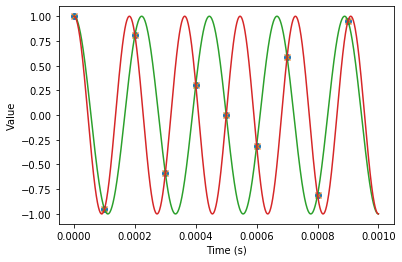

In [11]:
# Demonstrate aliasing

f1 = 4500
f2 = 5500
def signal(t,f):
    return np.cos(2*np.pi*f*t)

fs = 10000 # Sampling frequency
duration = .01
t = np.arange(0,1/1000.,1./fs)

plt.figure()
plt.plot(t,signal(t,f1),'o')
plt.plot(t,signal(t,f2),'x')
tmany = np.linspace(0,1/1000.0,1000)
plt.plot(tmany,signal(tmany,f1))
plt.plot(tmany,signal(tmany,f2))
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.show()

# Load some real data

This comes from the USGS: station USGS 11455420 SACRAMENTO R A RIO VISTA CA

![width=200px](https://waterdata.usgs.gov/nwisweb/local/state/ca/text/11455420_gh.jpg | width=400)


https://waterdata.usgs.gov/nwis/uv?cb_00010=on&cb_00065=on&cb_00095=on&format=gif_mult_parms&site_no=11455420&period=&begin_date=2019-09-28&end_date=2019-10-12

In [32]:
# This demonstrates how to read data from a file
filename = 'water_data.txt'
file = open(filename) # open the file for reading
# define python arrays to hold the variables
times = []
gage_height = []
temperature = []
specific_conductance = []
for line in file:
    if line[0] != 'U':
        # skip this line
        False # This doesn't do anything at all, but without it, Python doesn't know how to deal with an empty indented block
    else:
        fields = (line.strip()).split('\t') # strip off the return character from the end of the line, then split it into fields based on tabs
        times.append(fields[2])
        gage_height.append(float(fields[4]))
        temperature.append(float(fields[6]))
        specific_conductance.append(float(fields[8]))
file.close() # close the file

times = np.array(times,dtype='datetime64')
gage_height = np.array(gage_height)
temperature = np.array(temperature)
specific_conductance = np.array(specific_conductance)

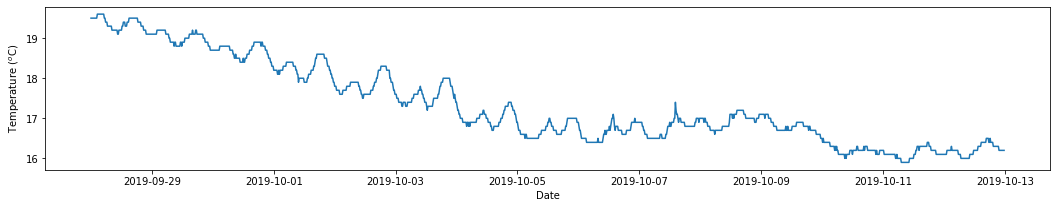

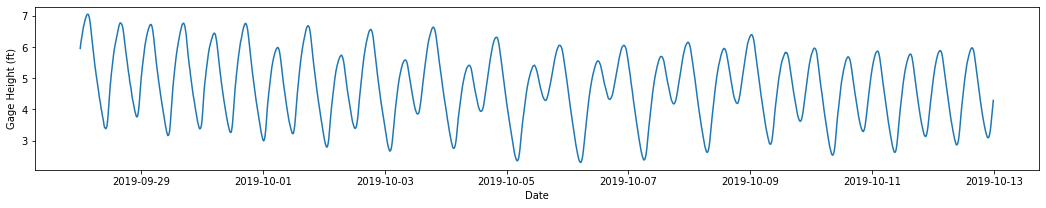

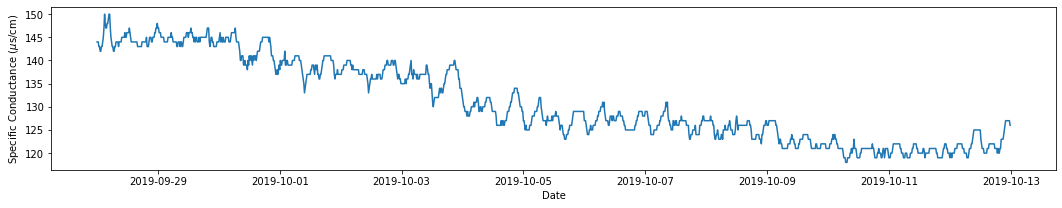

In [58]:
# exploratory plots
plt.figure(figsize=(18,3))
plt.plot(times,temperature)
plt.xlabel('Date')
plt.ylabel('Temperature ($^o$C)')
plt.show()
plt.figure(figsize=(18,3))
plt.plot(times,gage_height)
plt.xlabel('Date')
plt.ylabel('Gage Height (ft)')
plt.show()
plt.figure(figsize=(18,3))
plt.plot(times,specific_conductance)
plt.xlabel('Date')
plt.ylabel('Specific Conductance ($\mu$s/cm)')
plt.show()

# Find out what the time step (or sampling rate) is

In [46]:
delta_t = times[1]-times[0]
print(delta_t) # NOTE: Because times is a numpy time object, delta_t is a numpy timedelta object, so it is aware of units

15 minutes


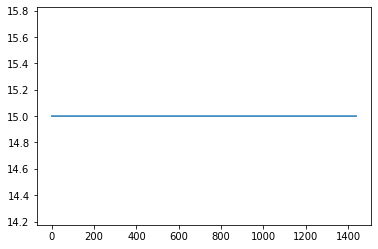

In [56]:
# check to see that data are uniformly spaced
deltas = np.diff(times)
# method 1 - just make a plot of the delta_time valuees:
plt.figure()
plt.plot(deltas)
plt.show()
# method 2 - use the numpy allclose command to see whether all of the values are close to 15 minutes:
# first, convert all of the values to floating point
dt = np.array(deltas,dtype='float64')
assert( np.allclose(dt,dt[0]) )

#  Detrend the signal

If we want to look at whether two signals are correlated, we may want to first remove the long-term trend from the signals before looking at short-term fluctuations. This operation can be viewed as a type of filtering. We'll look more at filtering and spectral analysis next week, but for now, this will do. We can detrend the signal either by using least squares fitting to calculate and remove the trendline or by using the detrend routine from scipy.signal.

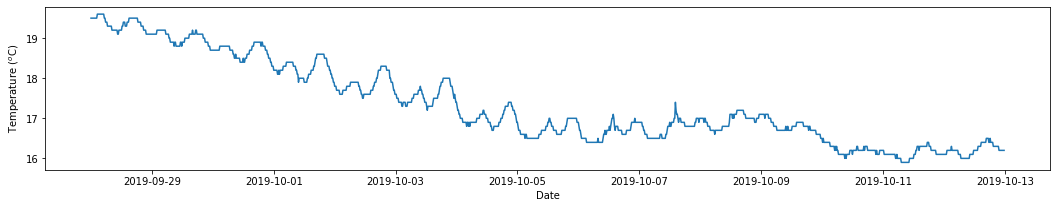

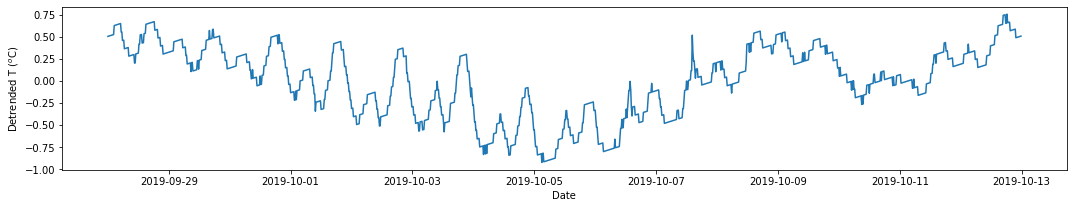

In [57]:
import scipy.signal as sig
detrended_temperature = sig.detrend(temperature)

plt.figure(figsize=(18,3))
plt.plot(times,temperature)
plt.xlabel('Date')
plt.ylabel('Temperature ($^o$C)')
plt.show()
plt.figure(figsize=(18,3))
plt.plot(times,detrended_temperature)
plt.xlabel('Date')
plt.ylabel('Detrended T ($^o$C)')
plt.show()

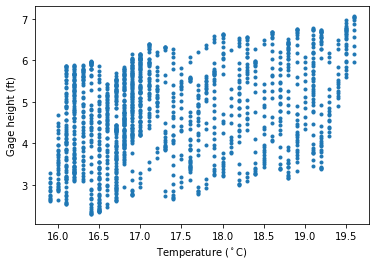

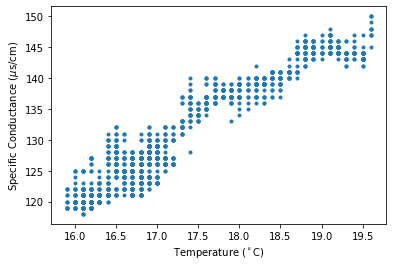

Correlation between temperature, gage height =  0.35318111480545294
Correlation between temperature, specific conductance =  0.9550330610765257


In [67]:
# Calculate the correlation coefficient between temperature and gage height
# first make a scatter plot
plt.figure()
plt.plot(temperature,gage_height,'.')
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Gage height (ft)')
plt.show()

plt.figure()
plt.plot(temperature,specific_conductance,'.')
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Specific Conductance ($\mu$s/cm)')
plt.show()

c_th = np.corrcoef(temperature,gage_height)
print('Correlation between temperature, gage height = ',c_th[1,0])
c_ts = np.corrcoef(temperature,specific_conductance)
print('Correlation between temperature, specific conductance = ',c_ts[1,0])

In [72]:
# calculate correlation of gage height with a shifted copy of itself
nshift=2
r = np.corrcoef(gage_height[:-nshift],gage_height[nshift:])
print('r=',r)
# pull out just the [1,0  entry]
r10 = r[1,0]
print('r[1,0]=',r10)

r= [[1.        0.9727402]
 [0.9727402 1.       ]]
r[1,0]= 0.972740196634737


In [93]:
###### let's calculate this using a bunch of different values of the delay:
# a delay of 1 corresponds to 15 minutes, so a delay of 96 is one day
nshift = np.arange(0,2*96+1)
r = []
for i in nshift:
    # special case for i==0
    if i == 0:
        r.append( np.corrcoef( gage_height,gage_height )[1,0] ) # note - this is always 1.0
    else:
        r.append( np.corrcoef( gage_height[:-i],gage_height[i:])[1,0] )
# r is a python array - convert it into a numpy array
r = np.array(r)

<IPython.core.display.Javascript object>


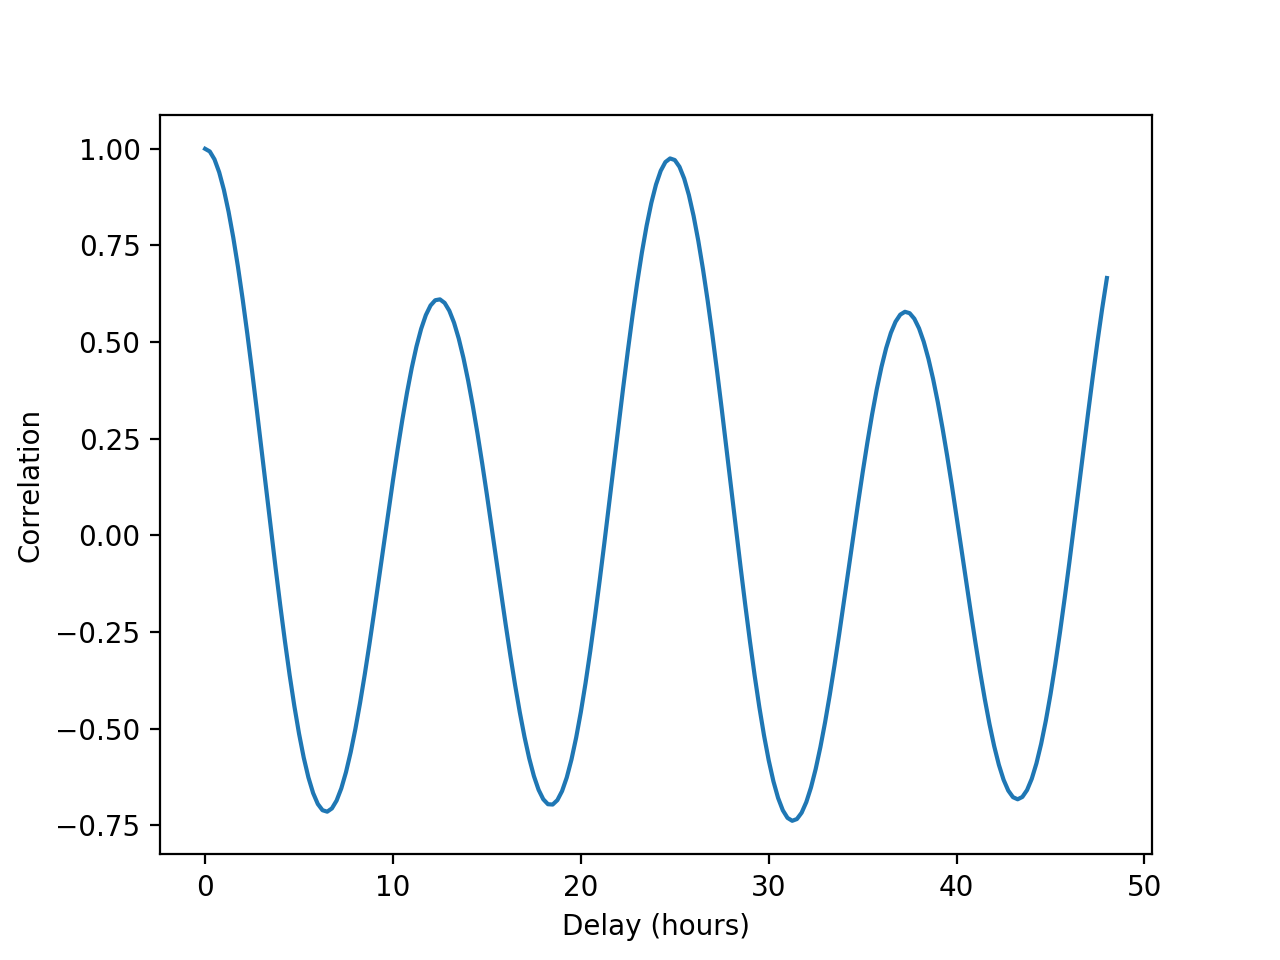

In [95]:
# plot the correlation vs. delay
%matplotlib notebook
plt.figure()
hours = np.array(nshift,dtype='float64')*15.0/60.0
plt.plot(hours,r)
plt.xlabel('Delay (hours)')
plt.ylabel('Correlation')
plt.show()